Preliminary Data Exploration

In [2]:
import os
import sys
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

project_dir = '../'
scripts_dir = os.path.join(project_dir, 'scripts')
sys.path.append(scripts_dir)

from boxplot import plot_boxplot

In [3]:
df = pd.read_parquet('../data/curated/tlc_yellow.parquet')
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount
0,2023-07-01 00:29:59,2023-07-01 00:40:15,1.0,1.80,140,263,1,12.10,5.10,22.20
1,2023-07-01 00:03:25,2023-07-01 00:23:44,1.0,2.31,163,163,2,19.10,0.00,24.10
2,2023-07-01 00:38:29,2023-07-01 00:48:53,1.0,2.36,142,262,1,13.50,3.70,22.20
3,2023-07-01 00:14:16,2023-07-01 00:29:13,1.0,4.36,68,24,1,19.80,4.96,29.76
4,2023-07-01 00:11:15,2023-07-01 00:20:47,0.0,1.60,161,107,1,11.40,3.25,19.65
...,...,...,...,...,...,...,...,...,...,...
18816601,2023-12-31 23:04:34,2023-12-31 23:13:58,NaN,1.34,233,163,0,12.08,0.00,16.08
18816602,2023-12-31 23:08:15,2023-12-31 23:08:23,NaN,0.00,48,48,0,25.98,0.00,27.48
18816603,2023-12-31 23:16:15,2023-12-31 23:30:28,NaN,3.71,196,198,0,16.68,0.00,18.18
18816604,2023-12-31 23:21:58,2023-12-31 23:34:29,NaN,5.20,140,148,0,19.64,0.00,23.64


**Time range**: To ensure that the dataset is within a specified time-range from the beginning of July 2023 to the end of December 2023.

In [4]:
# Define date range
start_date, end_date = pd.Timestamp("2023-07-01 00:00:00"), pd.Timestamp("2023-12-31 23:59:59")

# Filter by date range and apply initial cleaning
df_filtered = (
    df[(df["tpep_pickup_datetime"].between(start_date, end_date)) & 
       (df["trip_distance"] > 0) & 
       (df['payment_type'].isin([1, 2]))]
)

**Filter Unrealistic Values**: Remove entries with fares below $2.50 or negative tips, as these are likely errors or outliers that do not represent valid trips.




In [5]:
# Remove unrealistic fare and tip amounts, calculate trip duration
df_filtered = df_filtered[(df_filtered.fare_amount >= 2.5) & (df_filtered.tip_amount >= 0)]


**Calculate Trip Duration**: Compute the trip duration in minutes by finding the difference between pickup and dropoff times. This helps in analyzing the length of trips for further insights.

In [6]:
df_filtered['trip_time'] = (df_filtered.tpep_dropoff_datetime - df_filtered.tpep_pickup_datetime).dt.total_seconds() / 60

**Remove Negative Durations**: Exclude records with negative trip durations to ensure all remaining data reflects realistic and valid trip information.

In [7]:
df_filtered = df_filtered[df_filtered['trip_time'] >= 0]

**Legal speed limit**: filter out trips with average speeds exceeding 70 mph, ensuring only trips within the legal speed limit are retained for analysis.

In [8]:
df_filtered1 = df_filtered[(df_filtered.trip_distance / (df_filtered.trip_time / 60)) < 70]

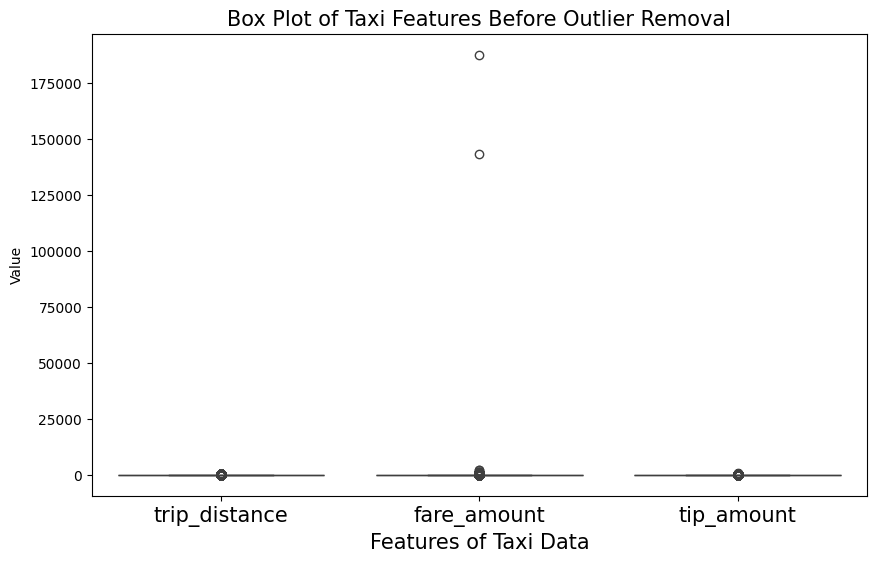

In [8]:
features = ['trip_distance', 'fare_amount', 'tip_amount']

plot_boxplot(df_filtered1, features, title='Box Plot of Taxi Features Before Outlier Removal', xlabel='Features of Taxi Data')
# plt.savefig('../plots/Boxplot_Taxi_Features_Before_Outlier_Removal.png')

As can be seen from the box plot, the fare_amount has two values that are obviously outliers. Hence, they'll be removed immediately before further proceding.

In [9]:
sorted_column = df_filtered['fare_amount'].sort_values(ascending=False)

print(sorted_column)

5856333     187502.96
6062118     143163.45
17399209      2194.70
10893853      1916.80
14403074      1726.60
              ...    
4392871          2.60
6461325          2.50
1454941          2.50
3434764          2.50
2981612          2.50
Name: fare_amount, Length: 17404649, dtype: float64


In [10]:
threshold = 10000

df_filtered1 = df_filtered1[df_filtered1['fare_amount'] <= threshold]

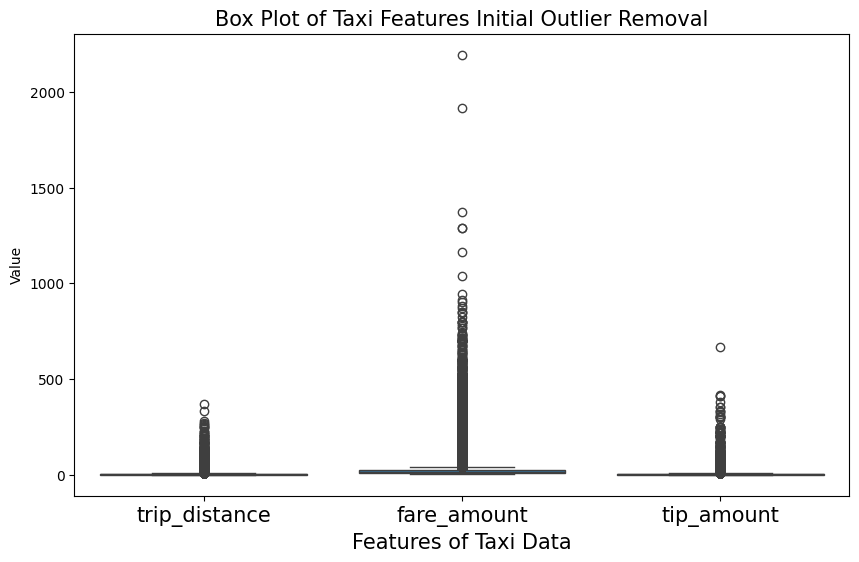

In [11]:
features = ['trip_distance', 'fare_amount', 'tip_amount']

plot_boxplot(df_filtered1, features, title='Box Plot of Taxi Features Initial Outlier Removal', xlabel='Features of Taxi Data')
# plt.savefig('../plots/Boxplot_Taxi_Features_Initial_Outlier_Removal.png')

In [12]:
# maximum reasonable values for each feature
max_values = {
    'trip_distance': 200,
    'fare_amount': 500,
    'tip_amount': 200
}

# constraints to filter 
def filter_by_max_values(df, constraints):
    filtered_df = df.copy()
    for column, max_value in constraints.items():
        filtered_df = filtered_df[filtered_df[column] < max_value]
    return filtered_df

df_filtered2 = filter_by_max_values(df_filtered1, max_values)

In [13]:
# remove data based on boxplot outliers
valid_trip_distance = df_filtered2.trip_distance < 200
valid_fare_amount = df_filtered2.fare_amount < 500
valid_tip_amount = df_filtered2.tip_amount < 200
df_filtered3 = df_filtered2[valid_trip_distance & valid_fare_amount & valid_tip_amount]


In [14]:
cols = ['trip_time', 'trip_distance', 'fare_amount', 'tip_amount']

# calculate and apply IQR-based outlier removal
Q1, Q3 = df_filtered3[cols].quantile(0.25), df_filtered3[cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 0.5 * IQR
df_filtered4 = df_filtered3[~((df_filtered[cols] < lower_bound) | (df_filtered[cols] > upper_bound)).any(axis=1)]



/tmp/ipykernel_2173/1976084194.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered4 = df_filtered3[~((df_filtered[cols] < lower_bound) | (df_filtered[cols] > upper_bound)).any(axis=1)]


In [15]:
# estimate and fill missing tip amounts
card_tips = df_filtered4[df_filtered4['payment_type'] == 1][['tip_amount', 'total_amount']]
tip_rate = card_tips['tip_amount'].sum() / card_tips['total_amount'].sum()
df_filtered4.loc[df_filtered4['payment_type'] == 2, 'tip_amount'] = (df_filtered4['total_amount'] - 2.5) * tip_rate
df_filtered4['total_with_tip'] = df_filtered4['total_amount'] + df_filtered4['tip_amount']



/tmp/ipykernel_2173/1772152997.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered4['total_with_tip'] = df_filtered4['total_amount'] + df_filtered4['tip_amount']


In [16]:
df_filtered4['earnings_rate'] = (df_filtered4['total_with_tip'] - 2.5) / df_filtered4['trip_time']



/tmp/ipykernel_2173/1936734772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered4['earnings_rate'] = (df_filtered4['total_with_tip'] - 2.5) / df_filtered4['trip_time']


In [17]:
features = [
    'PULocationID', 'DOLocationID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'total_with_tip', 'trip_distance', 'fare_amount', 'tip_amount', 'earnings_rate'
]
df_final = df_filtered4[features]
df_final['date'] = df_final['tpep_pickup_datetime'].dt.date

# group by 'PULocationID' and 'date' and aggregate data
processed_df = df_final.groupby(['PULocationID', 'date']).agg({
    'earnings_rate': 'mean',
    'total_with_tip': 'mean',
    'trip_distance': 'mean',
    'fare_amount': 'mean',
    'tip_amount': 'median'
}).reset_index()

/tmp/ipykernel_2173/1126216222.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['date'] = df_final['tpep_pickup_datetime'].dt.date


In [18]:
processed_df.to_csv('../data/curated/processed_taxi_data.csv', index=False)

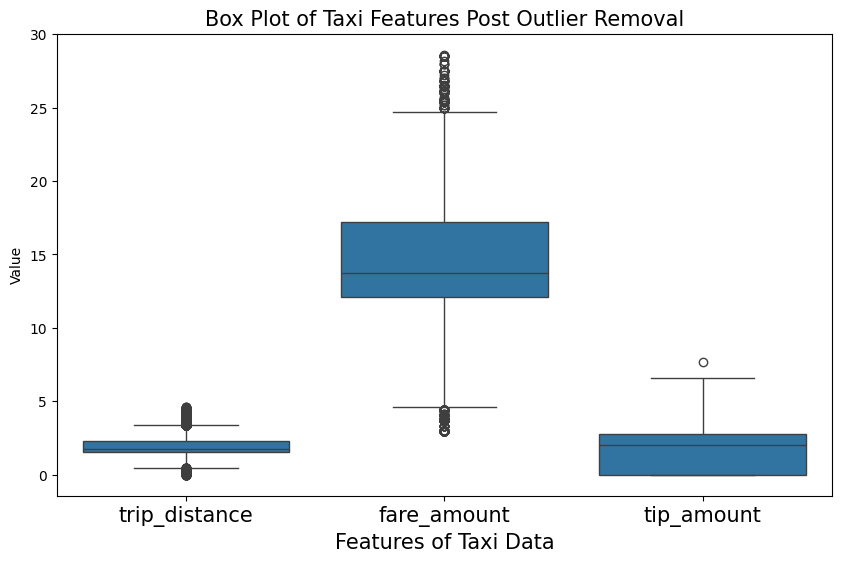

In [19]:
features = ['trip_distance', 'fare_amount', 'tip_amount']

plot_boxplot(processed_df, features, title='Box Plot of Taxi Features Post Outlier Removal', xlabel='Features of Taxi Data')
# plt.savefig('../plots/Boxplot_Taxi_Features_Post_Outlier_Removal.png')

In [20]:
cleaned = pd.read_csv('../data/curated/processed_taxi_data.csv')
cleaned.describe()

,PULocationID,earnings_rate,total_with_tip,trip_distance,fare_amount,tip_amount
count,30616.000000,30616.000000,30616.000000,30616.000000,30616.000000,30616.000000
mean,138.209564,2.700129,20.780148,1.910628,14.561113,1.709015
std,76.446158,10.154096,4.039606,0.736744,3.906207,1.295834
min,1.000000,0.107775,4.223047,0.010000,3.000000,0.000000
25%,72.000000,1.307743,18.690989,1.536323,12.075349,0.000000
50%,141.000000,1.759036,21.031513,1.783750,13.741483,2.050000
75%,209.000000,2.039065,23.013719,2.265000,17.183333,2.795523
max,265.000000,493.940154,70.490000,4.590000,28.600000,7.676536
